In [1]:
import numpy as np
import pandas as pd
import itertools
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("secondary_data.csv", delimiter=';')

# Drop columns with more than 40% missing values
threshold = len(data) * 0.6
data = data.dropna(thresh=threshold, axis=1)

# Drop rows with any missing values
data = data.dropna()

# Data Preparation
# Converting column 'class' into 0 and 1 ('p' -> 1, 'e' -> 0)
data['class'] = data['class'].replace({'p': 1, 'e': 0})

# Checking if the target variable (class) is balanced
class_distribution = data['class'].value_counts()
print("Class distribution:")
print(class_distribution)

# Variable types after removing label encoding
variable_types = data.dtypes
print("\nVariable types:")
print(variable_types)

# Show the dataset head without label encoding
print("\nDataset head without label encoding:")
print(data.head())

# Feature and target separation
X = data.drop('class', axis=1).values
y = data['class'].values.astype(int)

# Mapping feature names to indices
feature_names = data.columns.drop('class').tolist()
feature_indices = {name: idx for idx, name in enumerate(feature_names)}

# Define numerical and categorical features
numerical_features = ['cap-diameter', 'stem-height', 'stem-width']
categorical_features = [col for col in feature_names if col not in numerical_features]

numerical_indices = [feature_indices[name] for name in numerical_features]
categorical_indices = [feature_indices[name] for name in categorical_features]

def gini_impurity(y):
    classes = np.unique(y)
    impurity = 1.0
    for c in classes:
        p = np.sum(y == c) / len(y)
        impurity -= p ** 2
    return 2 * np.unique(y).size == 2 and 2 * p * (1 - p) or impurity  # Corresponds to ψ(a) = 2a(1 - a)

def entropy(y):
    classes = np.unique(y)
    ent = 0.0
    for c in classes:
        p = np.sum(y == c) / len(y)
        if p > 0:
            ent -= p * np.log2(p)
    return ent / 2  # Corresponds to ψ(a) = -[a/2 * log2(a) + (1 - a)/2 * log2(1 - a)]

def classification_error(y):
    classes, counts = np.unique(y, return_counts=True)
    p_max = np.max(counts) / len(y)
    return 1 - p_max

def sqrt_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) == 1:
        return 0.0
    p = counts[0] / len(y)
    return np.sqrt(p * (1 - p))  

Class distribution:
class
1    20121
0    16944
Name: count, dtype: int64

Variable types:
class                     int64
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object

Dataset head without label encoding:
   class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0      1         15.26         x           g         o                    f   
1      1         16.60         x           g         o                    f   
2      1         14.07         x           g         o                    f   
3      1         14.17         f           h         e       

In [2]:
# ===============================
# Node class
# ===============================

class Node:
    def __init__(self, depth=0):
        self.left = None
        self.right = None
        self.is_leaf = False
        self.feature_index = None
        self.threshold = None
        self.prediction = None
        self.depth = depth
        self.is_numerical = True
        self.impurity_decrease = 0.0  

    def decide(self, x):
        if self.is_numerical:
            if x[self.feature_index] <= self.threshold:
                return self.left
            else:
                return self.right
        else:
            if x[self.feature_index] == self.threshold:
                return self.left
            else:
                return self.right

    # method to compute the maximum depth of the tree
    def get_max_depth(self):
        if self.is_leaf:
            return self.depth
        else:
            return max(self.left.get_max_depth(), self.right.get_max_depth())

    # method to count the number of nodes in the tree
    def count_nodes(self):
        if self.is_leaf:
            return 1
        else:
            return 1 + self.left.count_nodes() + self.right.count_nodes()

# Decision Tree class with Post-Pruning
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini',
                 numerical_indices=None, max_features=None, random_state=None,
                 pruning_threshold=0.0):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.pruning_threshold = pruning_threshold  # New parameter for pruning

        if criterion == 'gini':
            self.impurity_func = gini_impurity
        elif criterion == 'entropy':
            self.impurity_func = entropy
        elif criterion == 'error':
            self.impurity_func = classification_error
        elif criterion == 'sqrt':
            self.impurity_func = sqrt_impurity
        else:
            raise ValueError("Unknown criterion.")

        self.numerical_indices = numerical_indices
        self.max_features = max_features
        self.random_state = random_state
        self._random_state = np.random.RandomState(self.random_state)
        self.feature_importances_ = None  # Initialize feature importances

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features)  # Initialize to zeros
        self.root = self._grow_tree(X, y)
        # Normalize feature importances
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        # Check stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           num_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            # Create a leaf node
            leaf = Node(depth=depth)
            leaf.is_leaf = True
            leaf.prediction = self._most_common_label(y)
            return leaf

        # Find the best split
        impurity_before = self.impurity_func(y)
        best_split = self._find_best_split(X, y, num_samples, impurity_before)

        if best_split['feature_index'] is None:
            # Cannot split further, create a leaf node
            leaf = Node(depth=depth)
            leaf.is_leaf = True
            leaf.prediction = self._most_common_label(y)
            return leaf

        # Calculate impurity decrease
        impurity_after = best_split['impurity']
        impurity_decrease = impurity_before - impurity_after

        # Check if impurity decrease meets the pruning threshold
        if impurity_decrease < self.pruning_threshold:
            # Prune the tree by making this node a leaf
            leaf = Node(depth=depth)
            leaf.is_leaf = True
            leaf.prediction = self._most_common_label(y)
            return leaf

        # Create internal node
        node = Node(depth=depth)
        node.feature_index = best_split['feature_index']
        node.is_numerical = best_split['is_numerical']
        node.threshold = best_split['threshold']
        node.is_leaf = False

        # Accumulate feature importances
        node.impurity_decrease = impurity_decrease
        self.feature_importances_[node.feature_index] += impurity_decrease

        # Recursively grow left and right subtrees
        node.left = self._grow_tree(best_split['left_X'], best_split['left_y'], depth + 1)
        node.right = self._grow_tree(best_split['right_X'], best_split['right_y'], depth + 1)
        return node

    def _find_best_split(self, X, y, num_samples, impurity_before):
        num_features_total = X.shape[1]

        # Determine number of features to consider at each split
        if self.max_features in ['sqrt', 'log2', 'auto']:
            if self.max_features == 'sqrt':
                max_features = max(1, int(np.sqrt(num_features_total)))
            elif self.max_features == 'log2':
                max_features = max(1, int(np.log2(num_features_total)))
            elif self.max_features == 'auto':
                max_features = max(1, int(np.sqrt(num_features_total)))  # 'auto' mapped to 'sqrt'
        elif isinstance(self.max_features, float):
            max_features = max(1, int(self.max_features * num_features_total))
        elif isinstance(self.max_features, int):
            max_features = self.max_features
        elif self.max_features is None:
            max_features = num_features_total
        else:
            raise ValueError("Invalid value for max_features.")

        # Ensure max_features does not exceed total number of features
        max_features = min(max_features, num_features_total)

        # Randomly select features
        if self.max_features is not None:
            features = self._random_state.choice(num_features_total, max_features, replace=False)
        else:
            features = range(num_features_total)

        # Evaluate splits
        best_split = {
            'impurity': np.inf,
            'feature_index': None,
            'threshold': None,
            'left_X': None,
            'left_y': None,
            'right_X': None,
            'right_y': None,
            'is_numerical': True
        }
        for feature_index in features:
            split = self._evaluate_feature(X, X[:, feature_index], y, feature_index, impurity_before, num_samples)
            if split['impurity'] < best_split['impurity']:
                best_split = split
        return best_split

    def _evaluate_feature(self, X, X_column, y, feature_index, impurity_before, num_samples):
        best_impurity = np.inf
        best_threshold = None
        best_splits = None
        best_is_numerical = True

        if feature_index in self.numerical_indices:
            # Numerical feature
            thresholds = np.unique(X_column.astype(float))
            # Limit the number of thresholds to speed up
            if len(thresholds) > 10:
                thresholds = np.percentile(X_column.astype(float), np.linspace(0, 100, num=10))
                thresholds = np.unique(thresholds)
            for threshold in thresholds:
                left_indices = X_column.astype(float) <= threshold
                right_indices = X_column.astype(float) > threshold
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue
                impurity_left = self.impurity_func(y[left_indices])
                impurity_right = self.impurity_func(y[right_indices])
                impurity = (len(y[left_indices]) * impurity_left + len(y[right_indices]) * impurity_right) / num_samples
                impurity_decrease = impurity_before - impurity
                if impurity < best_impurity and impurity_decrease >= 0.0:  # min_impurity_decrease fixed to 0
                    best_impurity = impurity
                    best_threshold = threshold
                    best_splits = {
                        'left_X': X[left_indices],
                        'left_y': y[left_indices],
                        'right_X': X[right_indices],
                        'right_y': y[right_indices]
                    }
                    best_is_numerical = True
        else:
            # Categorical feature
            categories = np.unique(X_column)
            # Optionally limit the number of categories
            if len(categories) > 10:
                # Take the top 10 most frequent categories
                counts = pd.Series(X_column).value_counts()
                categories = counts.index[:10]
            for category in categories:
                left_indices = X_column == category
                right_indices = X_column != category
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue
                impurity_left = self.impurity_func(y[left_indices])
                impurity_right = self.impurity_func(y[right_indices])
                impurity = (len(y[left_indices]) * impurity_left + len(y[right_indices]) * impurity_right) / num_samples
                impurity_decrease = impurity_before - impurity
                if impurity < best_impurity and impurity_decrease >= 0.0:  # min_impurity_decrease fixed to 0
                    best_impurity = impurity
                    best_threshold = category
                    best_splits = {
                        'left_X': X[left_indices],
                        'left_y': y[left_indices],
                        'right_X': X[right_indices],
                        'right_y': y[right_indices]
                    }
                    best_is_numerical = False

        return {
            'impurity': best_impurity,
            'feature_index': feature_index if best_threshold is not None else None,
            'threshold': best_threshold,
            'left_X': best_splits['left_X'] if best_splits else None,
            'left_y': best_splits['left_y'] if best_splits else None,
            'right_X': best_splits['right_X'] if best_splits else None,
            'right_y': best_splits['right_y'] if best_splits else None,
            'is_numerical': best_is_numerical
        }

    def _most_common_label(self, y):
        counts = np.bincount(y)
        return np.argmax(counts)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

    def _predict_sample(self, x, node):
        if node.is_leaf:
            return node.prediction
        else:
            return self._predict_sample(x, node.decide(x))

    # method to get the maximum depth of the tree
    def get_max_depth(self):
        return self.root.get_max_depth()

    #method to count the number of nodes in the tree
    def count_nodes(self):
        return self.root.count_nodes()

In [3]:
# Function to compute accuracy
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Custom train_test_split function
def train_test_split(X, y, test_size=0.2, random_state=None, stratify=None):
    if random_state is not None:
        np.random.seed(random_state)
    if stratify is None:
        # Shuffle the indices
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        # Split indices
        split_idx = int(len(X) * (1 - test_size))
        train_indices = indices[:split_idx]
        test_indices = indices[split_idx:]
    else:
        # Stratified splitting
        unique_classes, y_indices = np.unique(stratify, return_inverse=True)
        train_indices = []
        test_indices = []
        for class_idx in range(len(unique_classes)):
            class_indices = np.where(y_indices == class_idx)[0]
            np.random.shuffle(class_indices)
            split_idx = int(len(class_indices) * (1 - test_size))
            train_indices.extend(class_indices[:split_idx])
            test_indices.extend(class_indices[split_idx:])
        train_indices = np.array(train_indices)
        test_indices = np.array(test_indices)
        # Shuffle train and test indices
        np.random.shuffle(train_indices)
        np.random.shuffle(test_indices)
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    return X_train, X_test, y_train, y_test

In [4]:
# Custom KFold class
class KFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X):
        n_samples = len(X)
        indices = np.arange(n_samples)
        if self.shuffle:
            if self.random_state is not None:
                np.random.seed(self.random_state)
            np.random.shuffle(indices)
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        current = 0
        for fold_size in fold_sizes:
            val_indices = indices[current:current + fold_size]
            train_indices = np.concatenate((indices[:current], indices[current + fold_size:]))
            yield train_indices, val_indices
            current += fold_size

# Custom confusion_matrix function
def confusion_matrix(y_true, y_pred):
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    y_true_indices = np.array([label_to_index[label] for label in y_true])
    y_pred_indices = np.array([label_to_index[label] for label in y_pred])
    cm = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)
    np.add.at(cm, (y_true_indices, y_pred_indices), 1)
    return cm

# Custom classification_report function
def classification_report(y_true, y_pred, target_names=None, digits=5):
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    cm = confusion_matrix(y_true, y_pred)
    lines = []
    headers = ["precision", "recall", "f1-score", "support"]
    head_fmt = '{:>15}' * (len(headers) + 1)
    lines.append(head_fmt.format('', *headers))
    # For each label
    precisions = []
    recalls = []
    f1s = []
    supports = []
    for idx, label in enumerate(unique_labels):
        TP = cm[idx, idx]
        FP = cm[:, idx].sum() - TP
        FN = cm[idx, :].sum() - TP
        support = cm[idx, :].sum()
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        label_name = target_names[idx] if target_names else str(label)
        row_fmt = '{:>15}' + ('{:>15.' + str(digits) + 'f}') * 3 + '{:>15}'
        lines.append(row_fmt.format(label_name, precision, recall, f1, support))
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(support)
    # Compute averages
    avg_precision = np.average(precisions, weights=supports)
    avg_recall = np.average(recalls, weights=supports)
    avg_f1 = np.average(f1s, weights=supports)
    total_support = np.sum(supports)
    lines.append('')
    lines.append(row_fmt.format('avg / total', avg_precision, avg_recall, avg_f1, total_support))
    return '\n'.join(lines)

# Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# Hyperparameter tuning using cross-validation
def hyperparameter_tuning(X, y, param_grid, k=5, acceptable_accuracy_threshold=0.9):
    best_params = None
    best_score = 0  # Higher is better for accuracy
    best_model = None

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    print("Starting hyperparameter tuning...")

    def evaluate_params(params):
        cv_accuracies = []
        models = []
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            y_train_cv, y_val_cv = y[train_index], y[val_index]

            model = DecisionTree(
                max_depth=params['max_depth'],
                min_samples_split=params['min_samples_split'],
                criterion=params['criterion'],
                numerical_indices=numerical_indices,
                pruning_threshold=params['pruning_threshold']  # Include pruning_threshold
            )
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            acc = accuracy_score(y_val_cv, y_pred_cv)
            cv_accuracies.append(acc)
            models.append(model)

        avg_accuracy = np.mean(cv_accuracies)
        # Compute complexity metrics
        depths = [model.get_max_depth() for model in models]
        avg_depth = np.mean(depths)
        nodes = [model.count_nodes() for model in models]
        avg_nodes = np.mean(nodes)
        print(f"Params: {params}, Average CV Accuracy: {avg_accuracy:.5f}")
        return avg_accuracy, avg_depth, avg_nodes, params

    # Evaluate all parameter combinations in parallel
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_params)(params) for params in combinations
    )

    # Filter models that meet the acceptable accuracy threshold
    acceptable_models = [result for result in results if result[0] >= acceptable_accuracy_threshold]

    if not acceptable_models:
        print("No models met the acceptable accuracy threshold.")
        # Fallback to the model with the highest accuracy
        best_result = max(results, key=lambda x: x[0])
    else:
        # Sort acceptable models by accuracy (descending), then by complexity
        acceptable_models.sort(key=lambda x: (-x[0], x[1], x[2]))
        best_result = acceptable_models[0]

    best_accuracy, best_depth, best_nodes, best_params = best_result

    # Retrain the best model on the full training data
    best_model = DecisionTree(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        criterion=best_params['criterion'],
        numerical_indices=numerical_indices,
        pruning_threshold=best_params['pruning_threshold']
    )
    best_model.fit(X_train_full, y_train_full)

    print("\nBest hyperparameters found:")
    print(best_params)
    print(f"Best Average CV Accuracy: {best_accuracy:.5f}")

    return best_model, best_params

# Define hyperparameter grid for Decision Tree with pruning_threshold
param_grid_dt = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy', 'error', 'sqrt'],
    'pruning_threshold': [0.0, 0.01] 
}

# Perform hyperparameter tuning on the training data for Decision Tree 
best_dt_model, best_dt_params = hyperparameter_tuning(
    X_train_full,
    y_train_full,
    param_grid=param_grid_dt,
    k=5
)

# Retrain the best Decision Tree model on the full training set
best_dt_model = DecisionTree(
    max_depth=best_dt_params['max_depth'],
    min_samples_split=best_dt_params['min_samples_split'],
    criterion=best_dt_params['criterion'],
    numerical_indices=numerical_indices,
    pruning_threshold=best_dt_params['pruning_threshold']
)
best_dt_model.fit(X_train_full, y_train_full)

# Evaluate the Decision Tree model on the test set 
y_pred_test_dt = best_dt_model.predict(X_test)
test_accuracy_dt = accuracy_score(y_test, y_pred_test_dt)
test_loss_dt = 1 - test_accuracy_dt

print(f"\nDecision Tree Test accuracy with best hyperparameters: {test_accuracy_dt:.5f}")
print(f"Decision Tree Test 0-1 loss with best hyperparameters: {test_loss_dt:.5f}")

# Overfitting test for Decision Tree 
# Get predictions on the training data
y_pred_train_dt = best_dt_model.predict(X_train_full)

# Compute training accuracy
train_accuracy_dt = accuracy_score(y_train_full, y_pred_train_dt)
train_loss_dt = 1 - train_accuracy_dt

print(f"\nDecision Tree Training accuracy with best hyperparameters: {train_accuracy_dt:.5f}")
print(f"Decision Tree Training 0-1 loss with best hyperparameters: {train_loss_dt:.5f}")

# Print classification report and confusion matrix for the training set
print("\nDecision Tree Classification Report (Training Set):")
print(classification_report(y_train_full, y_pred_train_dt, target_names=['Edible', 'Poisonous'], digits=5))

print("Decision Tree Confusion Matrix (Training Set):")
print(confusion_matrix(y_train_full, y_pred_train_dt))

# Print classification report and confusion matrix for the test set
print("\nDecision Tree Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test_dt, target_names=['Edible', 'Poisonous'], digits=5))

print("Decision Tree Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_test_dt))

Starting hyperparameter tuning...

Best hyperparameters found:
{'max_depth': 20, 'min_samples_split': 2, 'criterion': 'gini', 'pruning_threshold': 0.0}
Best Average CV Accuracy: 0.99764

Decision Tree Test accuracy with best hyperparameters: 0.99838
Decision Tree Test 0-1 loss with best hyperparameters: 0.00162

Decision Tree Training accuracy with best hyperparameters: 0.99980
Decision Tree Training 0-1 loss with best hyperparameters: 0.00020

Decision Tree Classification Report (Training Set):
                     precision         recall       f1-score        support
         Edible        1.00000        0.99956        0.99978          13555
      Poisonous        0.99963        1.00000        0.99981          16096

    avg / total        0.99980        0.99980        0.99980          29651
Decision Tree Confusion Matrix (Training Set):
[[13549     6]
 [    0 16096]]

Decision Tree Classification Report (Test Set):
                     precision         recall       f1-score       

Starting hyperparameter tuning...

Best hyperparameters found:
{'max_depth': 8, 'min_samples_split': 2, 'criterion': 'error', 'pruning_threshold': 0.0}
Best Average CV Accuracy: 0.82925


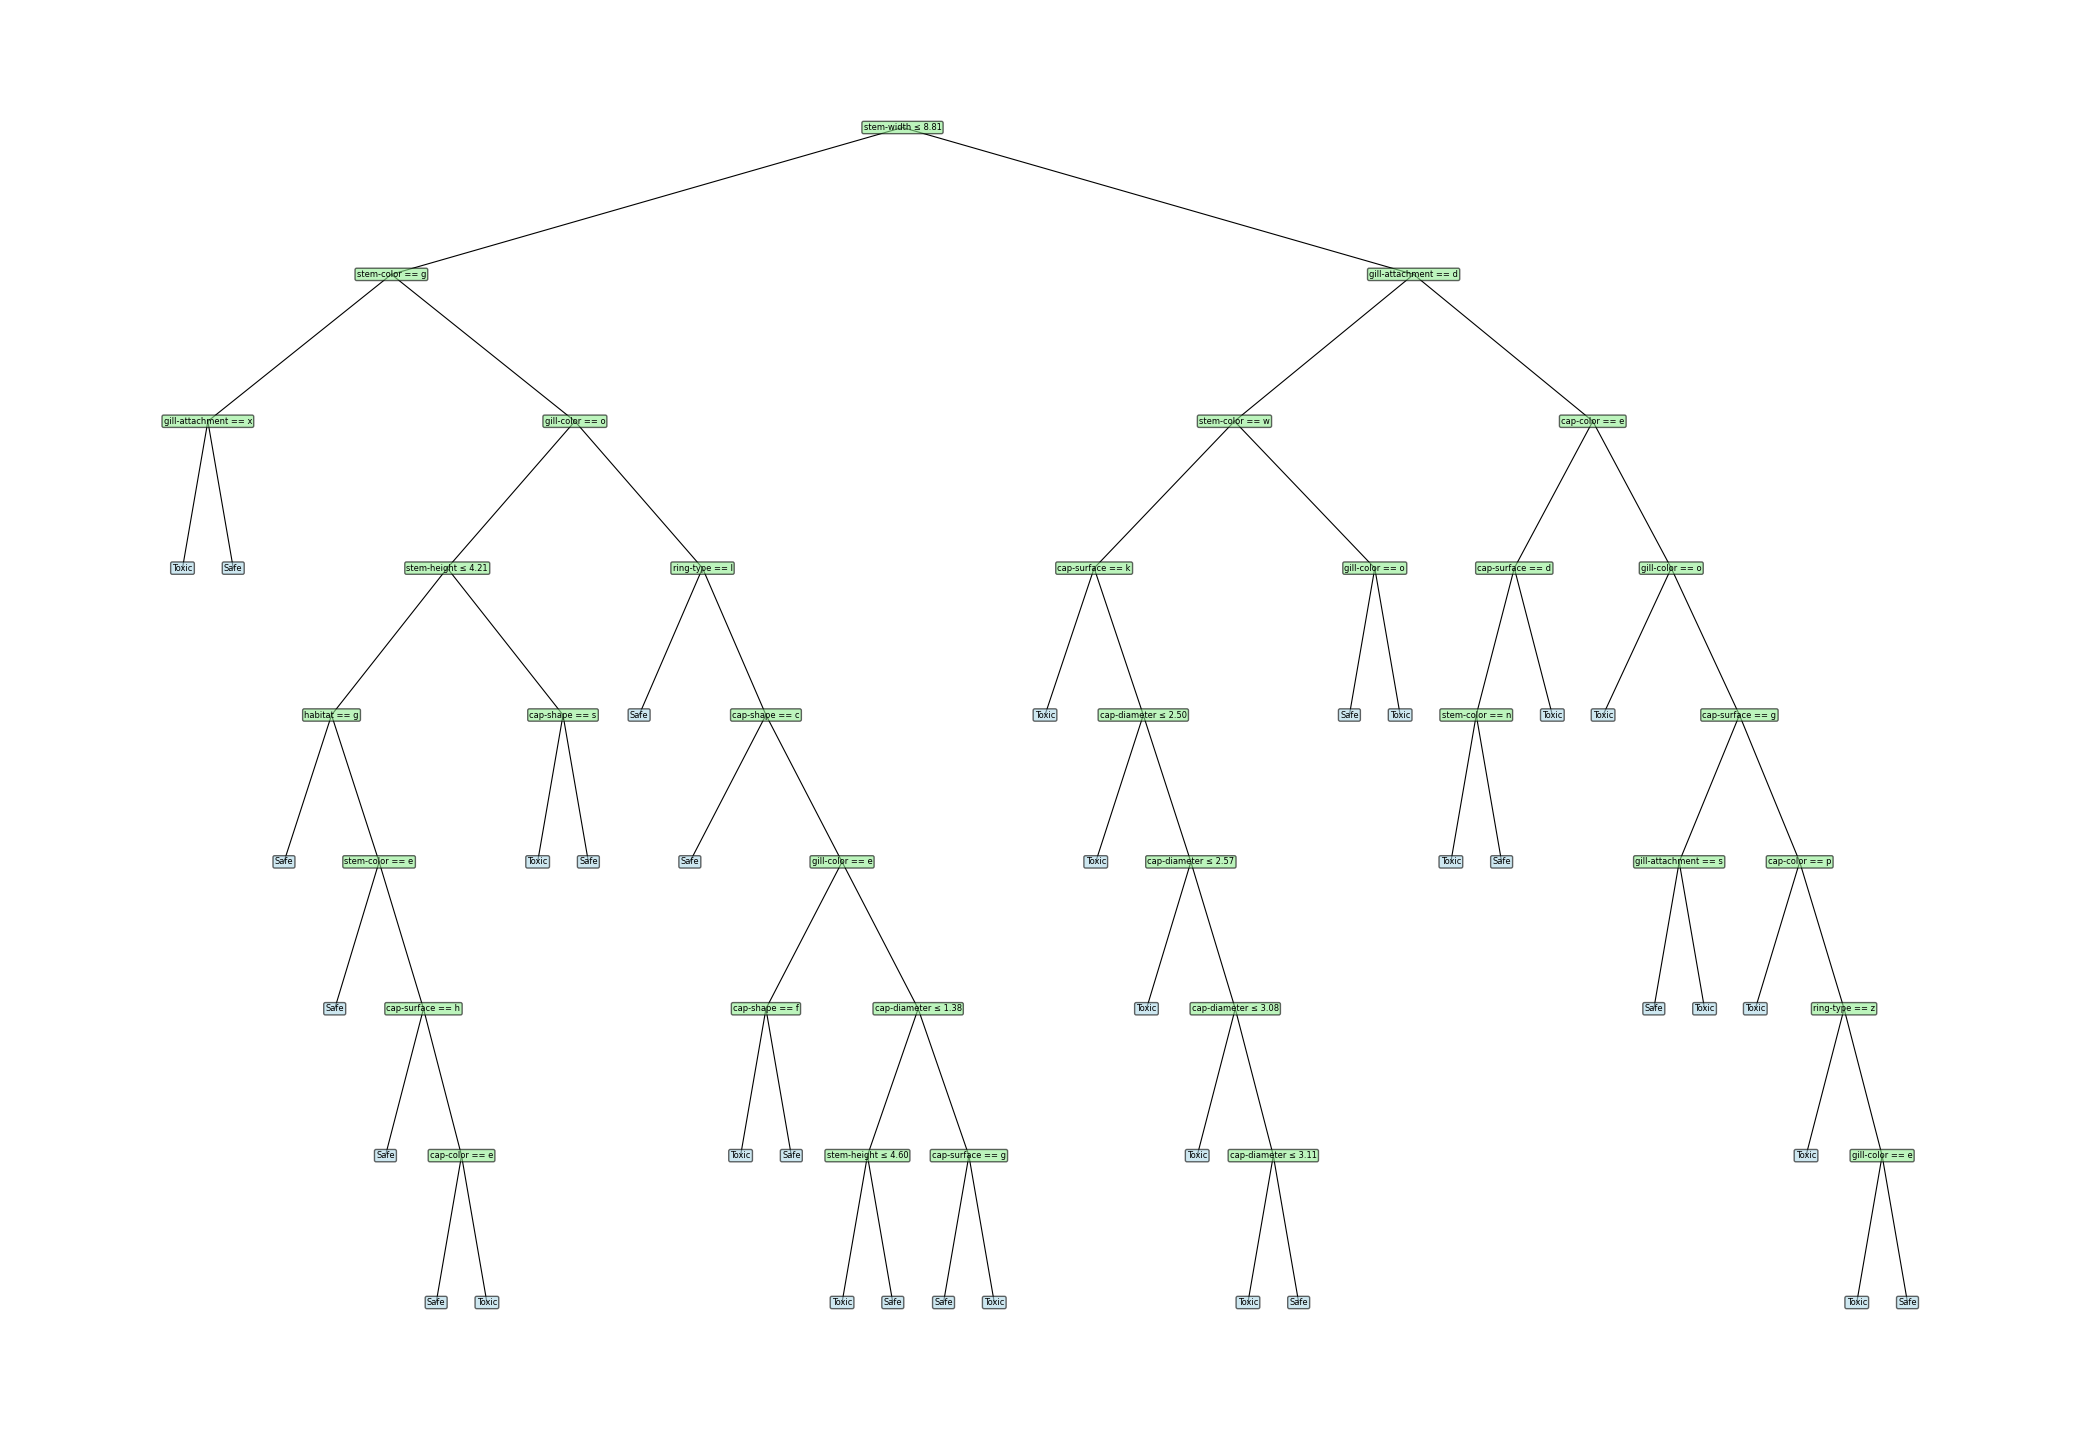

In [6]:
# ===============================
# Additional Hyperparameter Tuning for Visualization
# ===============================

# Define hyperparameter grid for Decision Tree (Visualization) with pruning_threshold
param_grid_visual = {
    'max_depth': [6, 7, 8],  # too much depth makes the tree unreadable in the visualization so a simpler tree is done for visualization
    'min_samples_split': [2],
    'criterion': ['error', 'sqrt'],
    'pruning_threshold': [0.0]  
}

# Perform hyperparameter tuning on the training data for Decision Tree (Visualization)
best_visual_model, best_visual_params = hyperparameter_tuning(
    X_train_full,
    y_train_full,
    param_grid=param_grid_visual,
    k=5,
    acceptable_accuracy_threshold=0.8  
)

# Retrain the best Decision Tree model for visualization on the full training set
best_visual_model = DecisionTree(
    max_depth=best_visual_params['max_depth'],
    min_samples_split=best_visual_params['min_samples_split'],
    criterion=best_visual_params['criterion'],
    numerical_indices=numerical_indices,
    pruning_threshold=best_visual_params['pruning_threshold']
)
best_visual_model.fit(X_train_full, y_train_full)

# Define the function to calculate the maximum depth of the tree
def get_max_depth(node):
    if node.is_leaf:
        return node.depth
    else:
        return max(get_max_depth(node.left), get_max_depth(node.right))

# First pass: Count the number of leaf nodes
def count_leaves(node):
    if node.is_leaf or node.depth >= max_depth_visual:
        return 1
    return count_leaves(node.left) + count_leaves(node.right)

# Second pass: Assign positions to nodes based on leaf order
def assign_positions(node, positions, depth, x_counter, max_depth=10):
    if node is None:
        return

    if node.is_leaf or depth >= max_depth:
        # Assign position to leaf or node at max_depth
        positions[node] = (x_counter[0] * horizontal_spacing, -depth * vertical_spacing)
        x_counter[0] += 1
        return

    # Traverse left subtree
    assign_positions(node.left, positions, depth + 1, x_counter, max_depth)

    # Assign current node's x as the midpoint between children
    left_x, _ = positions.get(node.left, (x_counter[0] * horizontal_spacing, -depth * vertical_spacing))

    # Traverse right subtree
    assign_positions(node.right, positions, depth + 1, x_counter, max_depth)
    right_x, _ = positions.get(node.right, (x_counter[0] * horizontal_spacing, -depth * vertical_spacing))

    # Set current node's position with increased horizontal scaling
    positions[node] = ((left_x + right_x) / 2, -depth * vertical_spacing)

# Define the function to plot each node with improved spacing and readability
def plot_tree_nodes(ax, node, positions, feature_names, class_names, max_depth=10):
    if node is None:
        return

    x, y = positions[node]

    if node.is_leaf or node.depth >= max_depth:
        # Leaf node or node at max_depth
        label = f'{class_names[node.prediction]}' if node.is_leaf else '...'
        bbox_props = dict(boxstyle='round,pad=0.2', facecolor='lightblue', edgecolor='black', alpha=0.6)
        ax.text(
            x, y, label,
            ha='center', va='center', fontsize=6,  # Further reduced font size
            bbox=bbox_props
        )
    else:
        # Internal node
        feature_name = feature_names[node.feature_index]
        threshold = node.threshold
        condition = "≤" if node.is_numerical else "=="
        # Format threshold to two decimal places if it's numerical
        if node.is_numerical:
            threshold = f"{threshold:.2f}"
        label = f'{feature_name} {condition} {threshold}'
        bbox_props = dict(boxstyle='round,pad=0.2', facecolor='lightgreen', edgecolor='black', alpha=0.6)
        ax.text(
            x, y, label,
            ha='center', va='center', fontsize=6, 
            bbox=bbox_props
        )

        # Get positions of child nodes
        left_child = node.left
        right_child = node.right

        if left_child in positions and right_child in positions:
            left_x, left_y = positions[left_child]
            right_x, right_y = positions[right_child]
            # Draw lines to children with decreased linewidth
            ax.plot([x, left_x], [y, left_y], 'k-', linewidth=0.8)
            ax.plot([x, right_x], [y, right_y], 'k-', linewidth=0.8)

            # Recursively plot child nodes
            plot_tree_nodes(ax, left_child, positions, feature_names, class_names, max_depth)
            plot_tree_nodes(ax, right_child, positions, feature_names, class_names, max_depth)

# Define the function to plot the entire decision tree
def plot_decision_tree_matplotlib(tree, feature_names, class_names, max_depth=10):
    global max_depth_visual
    max_depth_visual = max_depth  

    # Configuration for spacing
    global horizontal_spacing, vertical_spacing
    horizontal_spacing = 3.0   
    vertical_spacing = 2.5     

    # First, count the number of leaves to determine horizontal spacing
    total_leaves = count_leaves(tree.root)
    max_depth_tree = get_max_depth(tree.root)

    # Create figure and axis
    fig_width = min(25, total_leaves * 0.6)  
    fig_height = min(20, max_depth_tree * 1.8)  

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Store positions of nodes
    positions = {}
    # Initialize x_counter as a list to make it mutable within recursive calls
    x_counter = [0]

    # Assign positions to nodes using inorder traversal, limited to max_depth
    assign_positions(tree.root, positions, depth=0, x_counter=x_counter, max_depth=max_depth)

    # Plot the tree nodes and edges
    plot_tree_nodes(ax, tree.root, positions, feature_names, class_names, max_depth)

    # Set plot limits based on positions
    all_x = [pos[0] for pos in positions.values()]
    all_y = [pos[1] for pos in positions.values()]
    padding_x = max(2, (max(all_x) - min(all_x)) * 0.1) if all_x else 2  # Increased padding
    padding_y = max(2, (max(all_y) - min(all_y)) * 0.1) if all_y else 2  # Increased padding

    ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
    ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

    # Remove axes for a cleaner look
    ax.axis('off')

    # Improve layout
    plt.tight_layout()

    # Display the plot
    plt.show()

class_names = ['Safe', 'Toxic']  
plot_decision_tree_matplotlib(best_visual_model, feature_names, class_names, max_depth=best_visual_params['max_depth'])


In [7]:
# ===============================
# Random Forest class
# ===============================

class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 criterion='gini', max_features=None, numerical_indices=None,
                 pruning_threshold=0.0, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.max_features = max_features
        self.numerical_indices = numerical_indices
        self.pruning_threshold = pruning_threshold  # Added pruning_threshold
        self.random_state = random_state
        self._random_state = np.random.RandomState(self.random_state)
        self.trees = []
        self.feature_importances_ = None  # Initialize feature importances

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.feature_importances_ = np.zeros(n_features)  # Initialize feature importances

        # Function to build a single tree
        def build_tree(i):
            rng = np.random.RandomState(self._random_state.randint(0, 10000) + i)
            # Bootstrap sample
            indices = rng.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            # Create a tree
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion=self.criterion,
                numerical_indices=self.numerical_indices,
                max_features=self.max_features,
                random_state=rng.randint(0, 10000),
                pruning_threshold=self.pruning_threshold  # Pass pruning_threshold
            )
            tree.fit(X_sample, y_sample)
            return tree

        # Build trees in parallel
        self.trees = Parallel(n_jobs=-1)(
            delayed(build_tree)(i) for i in range(self.n_estimators)
        )

        # Aggregate feature importances
        for tree in self.trees:
            self.feature_importances_ += tree.feature_importances_

        # Normalize the feature importances
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance

    def predict(self, X):
        # Collect predictions from each tree
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote
        y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return y_pred

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [25, 50],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'criterion': ['gini', 'entropy', 'error', 'sqrt'],
    'max_features': ['sqrt', 'log2'],  
    'pruning_threshold': [0.0, 0.01]   
}

#hyperparameter_tuning function
def hyperparameter_tuning_rf(X, y, param_grid, k=5, model_class=RandomForest, fixed_params=None):
    best_params = None
    best_score = 0  # Higher is better for accuracy
    best_model = None

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    print("\nStarting Random Forest hyperparameter tuning...")

    def evaluate_params(params):
        cv_accuracies = []
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            y_train_cv, y_val_cv = y[train_index], y[val_index]

            model_params = params.copy()
            if fixed_params is not None:
                model_params.update(fixed_params)

            model = model_class(**model_params)
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            acc = accuracy_score(y_val_cv, y_pred_cv)
            cv_accuracies.append(acc)

        avg_accuracy = np.mean(cv_accuracies)
        print(f"Params: {params}, Average CV Accuracy: {avg_accuracy:.5f}")
        return avg_accuracy, params

    # Run evaluations in parallel
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_params)(params) for params in combinations
    )

    # Find the best hyperparameters based on the highest average accuracy
    for avg_accuracy, params in results:
        if avg_accuracy > best_score:
            best_score = avg_accuracy
            best_params = params

    # Retrain the best model on the full training data
    best_model_params = best_params.copy()
    if fixed_params is not None:
        best_model_params.update(fixed_params)
    best_model = model_class(**best_model_params)
    best_model.fit(X_train_full, y_train_full)

    print("\nBest hyperparameters found for Random Forest:")
    print(best_params)
    print(f"Best average CV Accuracy: {best_score:.5f}")

    return best_model, best_params

# Perform hyperparameter tuning on the training data for Random Forest
best_rf_model, best_rf_params = hyperparameter_tuning_rf(
    X_train_full,
    y_train_full,
    param_grid=param_grid_rf,
    k=5,
    model_class=RandomForest,
    fixed_params={'numerical_indices': numerical_indices, 'random_state': 42}
)

# Retrain the best Random Forest model on the full training set
best_rf_model = RandomForest(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    criterion=best_rf_params['criterion'],
    max_features=best_rf_params['max_features'],
    pruning_threshold=best_rf_params['pruning_threshold'],  # Pass pruning_threshold
    numerical_indices=numerical_indices,
    random_state=42
)
best_rf_model.fit(X_train_full, y_train_full)

# Evaluate the Random Forest model on the test set
y_pred_test_rf = best_rf_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
test_loss_rf = 1 - test_accuracy_rf

print(f"\nRandom Forest Test accuracy with best hyperparameters: {test_accuracy_rf:.5f}")
print(f"Random Forest Test 0-1 loss with best hyperparameters: {test_loss_rf:.5f}")

# Overfitting test for Random Forest
# Get predictions on the training data
y_pred_train_rf = best_rf_model.predict(X_train_full)

# Compute training accuracy
train_accuracy_rf = accuracy_score(y_train_full, y_pred_train_rf)
train_loss_rf = 1 - train_accuracy_rf

print(f"\nRandom Forest Training accuracy with best hyperparameters: {train_accuracy_rf:.5f}")
print(f"Random Forest Training 0-1 loss with best hyperparameters: {train_loss_rf:.5f}")

# Print classification report and confusion matrix for the training set
print("\nRandom Forest Classification Report (Training Set):")
print(classification_report(y_train_full, y_pred_train_rf, target_names=['Edible', 'Poisonous'], digits=5))

print("Random Forest Confusion Matrix (Training Set):")
print(confusion_matrix(y_train_full, y_pred_train_rf))

# Print classification report and confusion matrix for the test set
print("\nRandom Forest Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test_rf, target_names=['Edible', 'Poisonous'], digits=5))

print("Random Forest Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_test_rf))


Starting Random Forest hyperparameter tuning...

Best hyperparameters found for Random Forest:
{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 'sqrt', 'pruning_threshold': 0.0}
Best average CV Accuracy: 0.99936

Random Forest Test accuracy with best hyperparameters: 0.99973
Random Forest Test 0-1 loss with best hyperparameters: 0.00027

Random Forest Training accuracy with best hyperparameters: 0.99997
Random Forest Training 0-1 loss with best hyperparameters: 0.00003

Random Forest Classification Report (Training Set):
                     precision         recall       f1-score        support
         Edible        0.99993        1.00000        0.99996          13555
      Poisonous        1.00000        0.99994        0.99997          16096

    avg / total        0.99997        0.99997        0.99997          29651
Random Forest Confusion Matrix (Training Set):
[[13555     0]
 [    1 16095]]

Random Forest Classification Report (T


Feature Importances:
stem-width: 0.12422
cap-surface: 0.12091
gill-color: 0.10018
gill-attachment: 0.09861
cap-diameter: 0.09152
stem-height: 0.08704
stem-color: 0.07919
cap-shape: 0.07200
cap-color: 0.07011
habitat: 0.03944
ring-type: 0.03216
does-bruise-or-bleed: 0.03189
season: 0.03151
has-ring: 0.02122


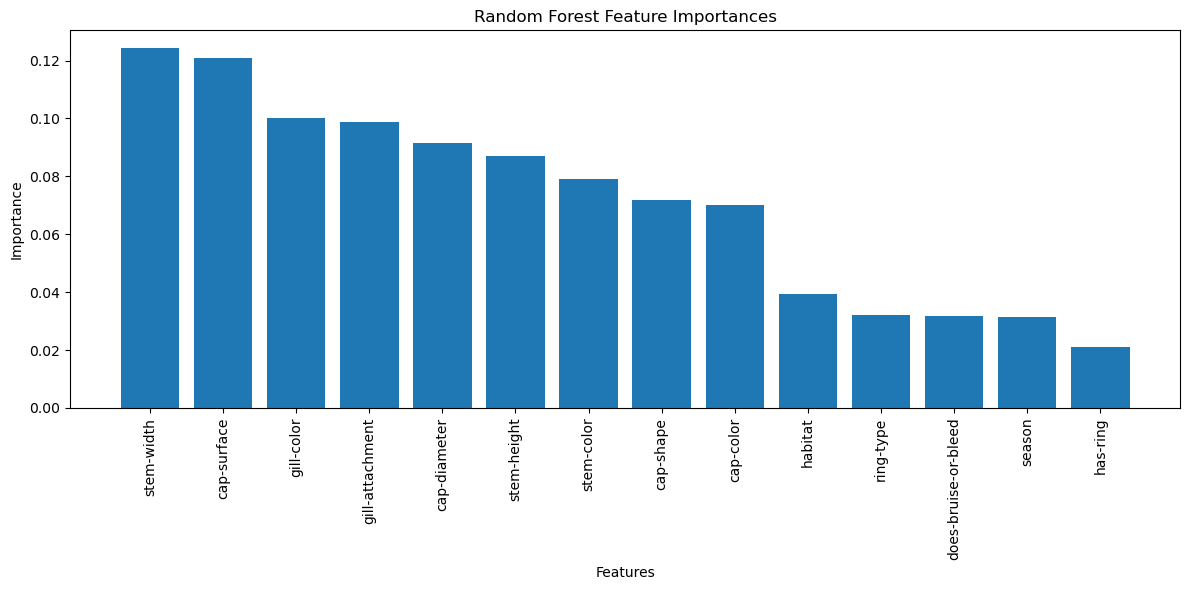

In [8]:
# ===============================
# Display feature importances
# ===============================

importances = best_rf_model.feature_importances_
# Map feature indices to feature names
feature_importance_dict = {feature_names[i]: importances[i] for i in range(len(feature_names))}
# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
# Print the feature importances
print("\nFeature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.5f}")

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), [val[1] for val in sorted_features], align='center')
plt.xticks(range(len(importances)), [val[0] for val in sorted_features], rotation=90)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
